In [1]:
import qutip
from qutip import basis, ket2dm, rand_ket, rand_dm, qeye, expect, tensor,identity
from enum import Enum
import numpy as np
from matplotlib import pyplot as plt
import scqubits
from typing import List 
from qiskit.algorithms.optimizers import COBYLA,ISRES,CRS,DIRECT_L
from IPython.display import clear_output

In [14]:
g = 0.02

In [15]:
# EJ = 8.9    
# EC = 2.5
# EL = 0.5
# E_osc = 11
# l_osc = 0

EJ = 14
EC = 1
EL = 0.5
E_osc = 5
l_osc = 2

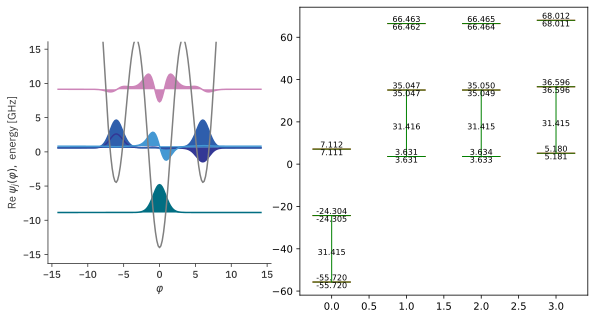

In [16]:

fluxonium = scqubits.Fluxonium(EJ = EJ,
                                EC = EC,
                                EL = EL,
                                flux = 0,
                                cutoff = 110)
osc = scqubits.Oscillator(
    E_osc=E_osc,
    l_osc = l_osc,
    truncated_dim=8
)
hilbertspace = scqubits.HilbertSpace([fluxonium, osc])
hilbertspace.add_interaction(
    g_strength=g, op1=fluxonium.n_operator, op2=osc.creation_operator, add_hc=True
)
hilbertspace.generate_lookup()
dessed_indices = [hilbertspace.dressed_index((0,0)),
                  hilbertspace.dressed_index((0,1)),
                  hilbertspace.dressed_index((1,0)),
                  hilbertspace.dressed_index((1,1)),
                  hilbertspace.dressed_index((2,0)),
                  hilbertspace.dressed_index((2,1))]
if None in dessed_indices:
    print('contain none')



def plot_specturum(fluxonium, osc, hilbertspace, max_qubit_level = 4,max_resonator_level=3,
                    flagged_transitions = [[[0,0],[0,1]],[[1,0],[1,1]],[[2,0],[2,1]],[[3,0],[3,1]]],message = ''):
    energy_text_size = 8
    clear_output(wait=True)
    qubit_ori_energies = fluxonium.eigenvals(max_qubit_level)
    resonator_ori_energies = osc.eigenvals(max_resonator_level)
    fig, old_ax = fluxonium.plot_wavefunction(which = [0,1,2,3,4])
    left, bottom, width, height = 1, 0, 1, 1  
    ax = fig.add_axes([left, bottom, width, height])
    fig.set_size_inches(4, 4)
    for ql in range(0,max_qubit_level):
        for rl in range(0,max_resonator_level):
            original = (qubit_ori_energies[ql] + resonator_ori_energies[rl])* 2 * np.pi
            x1,x2 = ql-0.25,ql+0.25
            ax.plot([x1, x2], [original, original], linewidth=1, color='red')
            ax.text(ql, original, f"{original:.3f}", fontsize=energy_text_size, ha='center', va='bottom')

            dressed_state_index = hilbertspace.dressed_index((ql,rl))
            if dressed_state_index != None:
                dressed = hilbertspace.energy_by_dressed_index(dressed_state_index)* 2 * np.pi
                ax.plot([x1, x2], [dressed, dressed], linewidth=1, color='green')
                ax.text(ql, dressed, f"{dressed:.3f}", fontsize=energy_text_size, ha='center', va='top')
            else:
                print("dressed_state_index contain None")

    for transition in flagged_transitions:
        state1, state2 = transition[0],transition[1]
        dressed_index1 = hilbertspace.dressed_index((state1[0],state1[1]))
        dressed_index2 = hilbertspace.dressed_index((state2[0],state2[1]))
        if dressed_index1!= None and dressed_index2!= None:
            energy1 = hilbertspace.energy_by_dressed_index(dressed_index1)* 2 * np.pi
            energy2 = hilbertspace.energy_by_dressed_index(dressed_index2)* 2 * np.pi
            ax.plot([state1[0], state2[0]], [energy1, energy2], linewidth=1, color='green')
            ax.text((state1[0]+ state2[0])/2, (energy1+ energy2)/2, f"{energy2-energy1:.3f}", fontsize=energy_text_size, ha='center', va='top')
        else:
            print("dressed_state_index contain None")
    plt.show()

plot_specturum(fluxonium, osc, hilbertspace)

In [17]:
(evals,) = hilbertspace["evals"]
diag_dressed_hamiltonian = (
        2 * np.pi * qutip.Qobj(np.diag(evals),
        dims=[hilbertspace.subsystem_dims] * 2)
)
def truncate(operator: qutip.Qobj, dimension: int) -> qutip.Qobj:
    return qutip.Qobj(operator[:dimension, :dimension])
total_truncation = 30
diag_dressed_hamiltonian_trunc = truncate(diag_dressed_hamiltonian, total_truncation)



def transition_frequency(s0: int, s1: int) -> float:
    # assert type(s0) == int, 'bad input'
    # assert type(s1) == int, 'bad input'
    return (
        (
            hilbertspace.energy_by_dressed_index(s1)
            - hilbertspace.energy_by_dressed_index(s0)
        )
        * 2 * np.pi
    )

In [18]:
def do_plots(omega_d,t_tot,kappa=None):
    # Plot the dressed state populations under drive
    #cos pulse
    def drive_coeff(t: float, *args: dict) -> float:
        return  np.cos(omega_d * t)


    a = hilbertspace.op_in_dressed_eigenbasis(op=osc.annihilation_operator)
    a = truncate(a, total_truncation)

    H_with_drive = [
        diag_dressed_hamiltonian_trunc,
        [A * 2 * np.pi * (a+a.dag()) , drive_coeff],  # driving through the resonator
    ]

    product_states = [(0, 0), (1, 0), (2,0), (0, 1), (1, 1), (2,1),(0,2)]
    idxs = [hilbertspace.dressed_index((s1, s2)) for (s1, s2) in product_states]
    qutip_states = [qutip.basis(total_truncation, idx) for idx in idxs]
    tlist = np.linspace(0, t_tot, t_tot*4)
    results = []
    if kappa != None:
        c_ops=[np.sqrt(kappa) * a]
    else:
        c_ops=[]
    for i in range(3):
        temp = qutip.mesolve(
            H = H_with_drive,
            rho0 = qutip.basis(total_truncation, hilbertspace.dressed_index((i,0))),
            tlist = tlist,
            e_ops=[state * state.dag() for state in qutip_states]+[a,
                                                                a.dag()*a, #photon number
                                                                0.5*(a+a.dag()), # real alpha
                                                                -0.5*1j*(a-a.dag())# imag alpha
                                                                ],
            # c_ops=c_ops,
            options=qutip.Options(store_final_state=True),
            # progress_bar = True
        )
        results.append(temp)

    dictionary = {0: 'g', 1: 'e', 2: 'f', 3: 'h'}

    fig, axes = plt.subplots(4, 3, figsize=(9, 6))

    for i in range(3):
        for idx, res in zip(idxs, results[i].expect):
            product_state = product_states[idxs.index(idx)]
            qubit_state = dictionary[product_state[0]]
            resonator_state = product_state[1]
            axes[0][i].plot(tlist, res, label=r"$|%s\rangle$" % (str(",".join([qubit_state,str(resonator_state)]))))
        alpha = results[i].expect[-4]*np.exp(1j*omega_d*tlist)
        real = alpha.real
        imag = alpha.imag
        axes[0][i].plot(tlist, results[i].expect[-3], label=r"photon number")
        axes[1][i].plot(tlist,imag , label=r"imag alpha")
        axes[2][i].plot(tlist, real, label=r"real alpha")
        axes[3][i].plot(-imag, real, label=r"imag alpha VS real alpha")

    axes[0][2].legend(loc='center', ncol=1, bbox_to_anchor=(1.5, 0.5))
    axes[1][2].legend(loc='center', ncol=1, bbox_to_anchor=(1.3, 0.5))
    axes[2][2].legend(loc='center', ncol=1, bbox_to_anchor=(1.3, 0.5))
    axes[3][2].legend(loc='center', ncol=1, bbox_to_anchor=(1.4, 0.5))
    plt.ylabel("population")
    plt.xlabel("t (ns)")
    for row in range(4):
        max_x_range,min_x_range,max_y_range,min_y_range = 0,0,0,0
        for col in [0,1,2]:
            ymin, ymax = axes[row][col].get_ylim()
            xmin, xmax = axes[row][col].get_xlim()
            if ymax > max_y_range:
                max_y_range = ymax
            if ymin < min_y_range:
                min_y_range = ymin
            if xmax > max_x_range:
                max_x_range = xmax
            if xmin < min_x_range:
                min_x_range = xmin
        for col in [0,1,2]:
            axes[row][col].set_ylim(min_y_range, max_y_range)
            axes[row][col].set_xlim(min_x_range,max_x_range)
    # plt.yscale('log')
    plt.figure()
    plt.plot(tlist,results[0].expect[-3],label='g0 photon #')
    plt.plot(tlist,results[1].expect[-3],label='e0 photon #')
    plt.plot(tlist,results[2].expect[-3],label='f0 photon #')
    plt.plot(tlist,results[0].expect[3],label='g1 population')
    plt.plot(tlist,results[1].expect[1],label='e0 population')
    plt.plot(tlist,results[2].expect[2],label='f0 population')
    plt.legend()
    plt.xlim(t_tot-20,t_tot)
    plt.ylim(0,1)
    plt.show()

    return results

# Erasure detection g0-g1

chi:0.41371738039044814


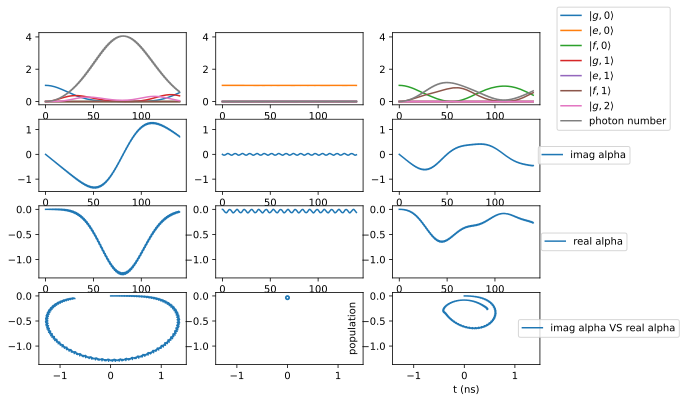

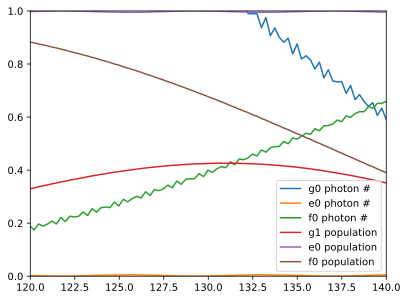

In [13]:
omega_g0g1 = transition_frequency(hilbertspace.dressed_index((0,0)), hilbertspace.dressed_index((0,1)))
omega_e0e1 = transition_frequency(hilbertspace.dressed_index((1,0)), hilbertspace.dressed_index((1,1)))
omega_d = (omega_g0g1)


chi = abs(omega_e0e1-omega_g0g1)/2
kappa = 2*chi
print(f'chi:{chi}')
A = 0.01 
# A = np.sqrt(10)*chi
# t_tot = int( np.pi/chi) # ns
t_tot = 140
results_g0g1 = do_plots(omega_d,t_tot,kappa)



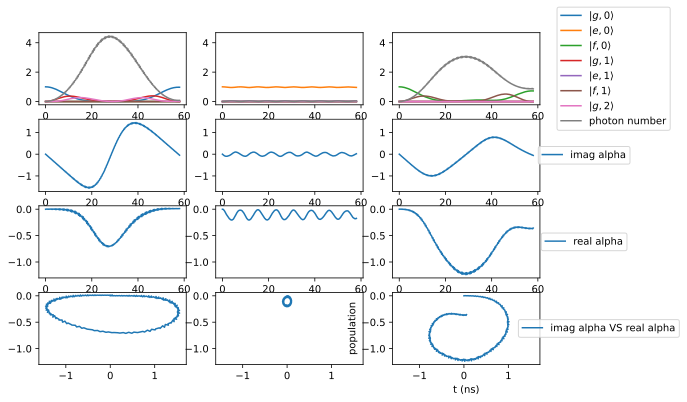

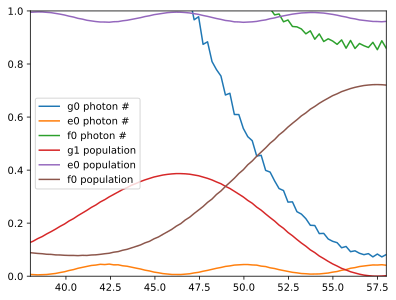

In [36]:
A = 0.03
t_tot = 58
omega_g0g1 = transition_frequency(hilbertspace.dressed_index((0,0)), hilbertspace.dressed_index((0,1)))
results_g0g1 = do_plots(omega_g0g1,t_tot)



(<Figure size 1000x500 with 3 Axes>, (<Axes3D: >, <Axes: >))

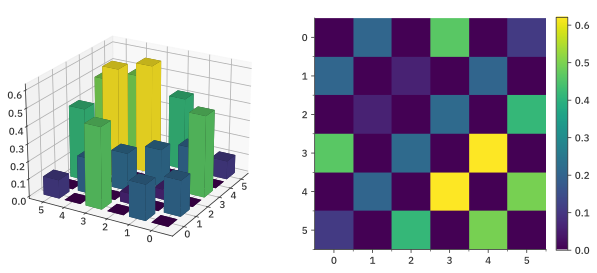

In [24]:
fluxonium.plot_matrixelements(operator = 'n_operator')

# Computational state measurement, f0-f1

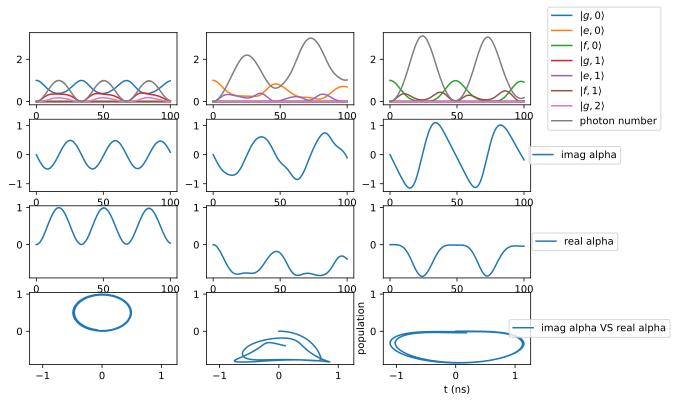

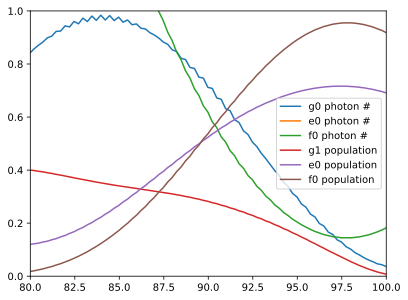

In [22]:
omega_e0e1 = transition_frequency(hilbertspace.dressed_index((1,0)), hilbertspace.dressed_index((1,1)))
omega_f0f1 = transition_frequency(hilbertspace.dressed_index((2,0)), hilbertspace.dressed_index((2,1)))
chi = abs(omega_f0f1-omega_e0e1)/2
omega_d = (omega_f0f1)


# t_tot = int(np.pi/chi) # ns
t_tot = 100
A = 0.03

results_f0f1 = do_plots(omega_d,t_tot)



# Computational state measurement, middle of e0-e1 and f0-f1

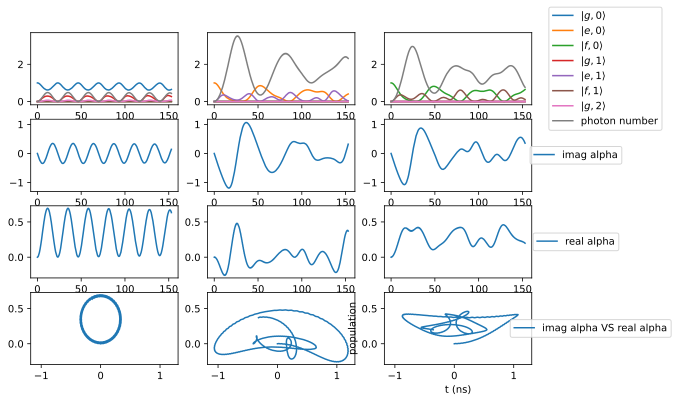

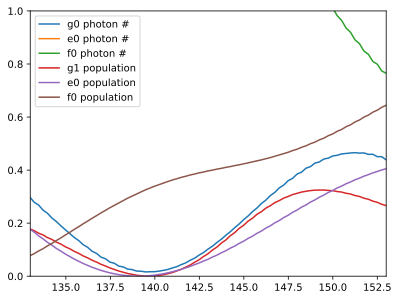

In [16]:
omega_e0e1 = transition_frequency(hilbertspace.dressed_index((1,0)), hilbertspace.dressed_index((1,1)))
omega_f0f1 = transition_frequency(hilbertspace.dressed_index((2,0)), hilbertspace.dressed_index((2,1)))
omega_d = (omega_e0e1+omega_f0f1)/2


t_tot = 153 # ns


results_middle = do_plots(omega_d,t_tot)



# Erasure detection rate for g/e/f

In [21]:
num_levels = results_g0g1[0].final_state.shape[0]
qubit_levels = 0
osc_levels = 0
for level in range(num_levels):
    (ql,ol) = hilbertspace.bare_index(level)
    if ql+1 > qubit_levels:
        qubit_levels = ql+1
    if ol+1 > osc_levels:
        osc_levels = ol+1

In [23]:

d = {
    'drive_g0g1': results_g0g1,
    'drive_middle_e0e1_f0f1': results_middle,
}

qubit_level = {
    0:'g',
    1: 'e',
    2: 'f'
}

for drive_type in d:
    for initial_state in [0,1,2]:
        final_state = d[drive_type][initial_state].final_state
        product_state = qutip.Qobj(dims = [[qubit_levels,osc_levels],[1,1]])
        for level in range(num_levels):
            (ql,ol) = hilbertspace.bare_index(level)
            product_state += complex(final_state[level]) * qutip.tensor(qutip.basis(qubit_levels, ql), qutip.basis(osc_levels, ol))
        osc_basis_states = [basis(osc_levels, i) for i in range(osc_levels)]
        projection_operators = [tensor(identity(qubit_levels),ket2dm(basis_state)) for basis_state in osc_basis_states]
        measurement_outcomes = [expect(projection_operator, product_state) for projection_operator in projection_operators]
        print(f'for {drive_type} on initial state {qubit_level[initial_state]}, the expectation of resonator in |0> is {measurement_outcomes[0]}')

for drive_g0g1 on initial state g, the expectation of resonator in |0> is 0.7825415869182318
for drive_g0g1 on initial state e, the expectation of resonator in |0> is 0.9999964246636149
for drive_g0g1 on initial state f, the expectation of resonator in |0> is 0.9969694592897088
for drive_middle_e0e1_f0f1 on initial state g, the expectation of resonator in |0> is 0.9974275767921311
for drive_middle_e0e1_f0f1 on initial state e, the expectation of resonator in |0> is 0.877918881498626
for drive_middle_e0e1_f0f1 on initial state f, the expectation of resonator in |0> is 0.8826606845705952
